In [1]:
# !pip install split-folders

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [3]:
# Importing Deep learning modules
from  tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D , Dropout
from keras.preprocessing.image import ImageDataGenerator
from  tensorflow.keras import Sequential , Input

In [4]:
# constants
IMAGE_SIZE= 64
CHANNELS=3
SEED_TRAINING=121
SEED_TESTING=197
SEED_VALIDATION=164
EPOCHS=30
BATCH_SIZE=32 


# Split into Train Test and Validation Folders in ratio
* Training : 70%
* Testing : 20%
* Validation : 10%

In [5]:
import splitfolders , os

DATASET_DIR = '../Datasets/Potato'
WORKING_DIR = './Dataset'

if not (os.path.exists(WORKING_DIR) and os.path.isdir(WORKING_DIR)):
    # Split the dataset into train, validation, and test sets
    splitfolders.ratio(DATASET_DIR, output=WORKING_DIR, seed=SEED_TRAINING, ratio=(0.7, 0.2, 0.1))

# Data Augmentation: 
ImageDataGenerator provides a wide range of built-in image data augmentation techniques, such as rotation, zooming, shearing, and flipping. This allows you to generate augmented images on-the-fly during training, which can help improve model generalization and performance.

## Advantages

* Customization: You can easily customize the data augmentation settings, including the type and intensity of augmentation, to suit your specific dataset and problem.

* Compatibility: ImageDataGenerator is compatible with various data formats, including NumPy arrays, Python generators, and directories containing images. This flexibility makes it suitable for a wide range of use cases.

* Fine-Tuned Control: It provides fine-tuned control over data loading and preprocessing, enabling you to apply different data augmentation techniques to the training and validation datasets.

* Integration with Model Training: You can directly integrate ImageDataGenerator with Keras model training using the fit_generator method, making it easy to perform data augmentation during model training.



In [6]:
train_dir = WORKING_DIR +"/train"
test_dir = WORKING_DIR +"/test"
val_dir = WORKING_DIR +"/val"


# rotation_range=10,     # Randomly rotate images by up to 10 degrees
#     width_shift_range=0.1, # Randomly shift images horizontally by up to 10% of width
#     height_shift_range=0.1,# Randomly shift images vertically by up to 10% of height
#     shear_range=0.2,       # Shear intensity
#     zoom_range=0.2,        # Zoom intensity
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest'    # Fill pixels using the nearest value if augmented

train_img_generator =  ImageDataGenerator(
        rescale=1./255,
         rotation_range=10,
         zoom_range=0.2,
        horizontal_flip=True ,
        )

test_img_generator =  ImageDataGenerator(rescale=1./255)
val_img_generator =  ImageDataGenerator(rescale=1./255)

In [7]:
def data_generator( img_generator,  dir ):
    return img_generator.flow_from_directory(
        dir, 
        target_size=(IMAGE_SIZE , IMAGE_SIZE),
        batch_size= BATCH_SIZE,
         class_mode="sparse",
          color_mode="rgb", 
          )

In [8]:
# Applying our generators to our data
train_generator = data_generator(train_img_generator, train_dir)
test_generator = data_generator(test_img_generator ,  test_dir)
val_generator = data_generator(val_img_generator , val_dir)

Found 1824 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 520 images belonging to 3 classes.


In [9]:
train_generator.n , test_generator.n , val_generator.n

(1824, 328, 520)

In [10]:
disease_class = list(train_generator.class_indices.keys())
num_of_classes = len(disease_class)
disease_class 

['Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight']

# visualizing

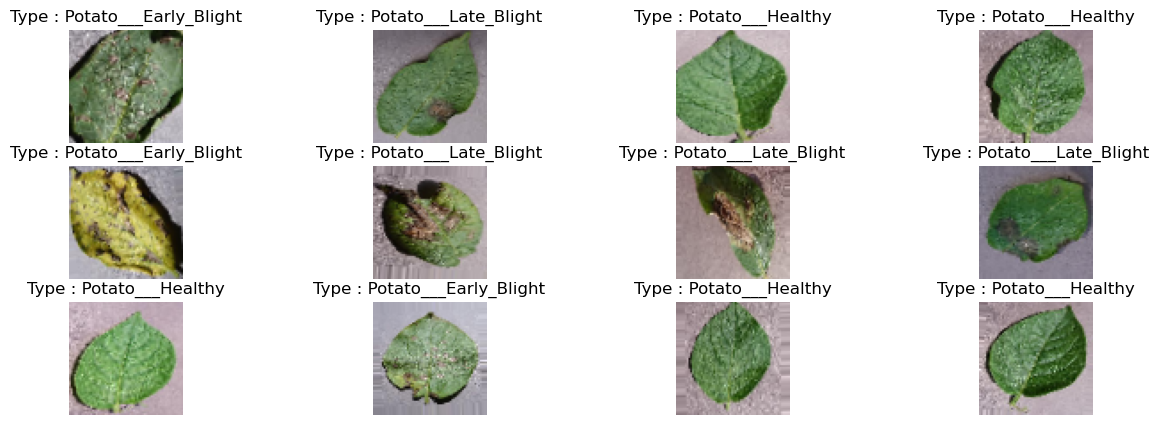

In [11]:
plt.figure( figsize= (15 , 5 ))

num_images_to_display = 12

for image_batch,label_batch in train_generator :
    # print(image_batch.shape , label_batch)

    for index in range(num_images_to_display):
        ax = plt.subplot( 3 , 4 , index + 1)
        plt.title('Type : ' +  disease_class[ int(label_batch[index])] )
        plt.imshow(image_batch[index])
        plt.axis('off')
    break
    

# Traing Model using CNN 

In [12]:
model=  Sequential([
   
   Conv2D(filters = 32 , kernel_size = (3,3) , input_shape = (IMAGE_SIZE , IMAGE_SIZE , CHANNELS) , activation = 'relu'),
   MaxPooling2D( pool_size=(3, 3), strides=2, padding='same'),
   
   Conv2D(16, kernel_size=(2, 2),  activation='relu', padding='same'),
   MaxPooling2D( (2, 2), 2, padding='same'),
   
   Flatten(),

   Dropout(rate=0.25),
   Dense(units = 10 , activation = 'relu'),
   Dropout(rate=0.5),
   Dense( num_of_classes , activation = 'softmax' ),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 4)         260       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 4)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [13]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from  tensorflow.keras.optimizers import Adam

In [14]:
train_generator.n , train_generator.samples , train_generator.batch_size

(1824, 1824, 32)

In [15]:
training_sets =train_generator.samples // train_generator.batch_size
testing_sets =test_generator.samples // test_generator.batch_size
validation_sets =val_generator.samples // val_generator.batch_size

training_sets , testing_sets , validation_sets

(57, 10, 16)

In [16]:
model.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model_history = model.fit(
    train_generator,
    steps_per_epoch=training_sets,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_sets
    )

Epoch 1/30


c:\Users\hp\anaconda3\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 53s 909ms/step - loss: 1.0751 - accuracy: 0.4084 - val_loss: 0.9890 - val_accuracy: 0.4746
Epoch 2/30
57/57 [==============================] - 8s 134ms/step - loss: 0.9475 - accuracy: 0.5504 - val_loss: 0.7742 - val_accuracy: 0.7832
Epoch 3/30
57/57 [==============================] - 8s 136ms/step - loss: 0.8139 - accuracy: 0.6113 - val_loss: 0.6693 - val_accuracy: 0.6426
Epoch 4/30
57/57 [==============================] - 8s 140ms/step - loss: 0.7084 - accuracy: 0.6727 - val_loss: 0.5102 - val_accuracy: 0.7969
Epoch 5/30
57/57 [==============================] - 8s 146ms/step - loss: 0.6752 - accuracy: 0.6848 - val_loss: 0.4564 - val_accuracy: 0.8184
Epoch 6/30
57/57 [==============================] - 9s 156ms/step - loss: 0.5833 - accuracy: 0.7292 - val_loss: 0.3643 - val_accuracy: 0.8730
Epoch 7/30
57/57 [==============================] - 11s 184ms/step - loss: 0.5524 - accuracy: 0.7478 - val_loss: 0.3018 - val_accuracy: 0.9375
Epoch 8/30
57/5

In [17]:
score = model.evaluate(test_generator)
print('Accuracy : ' , score[1])
print('Loss : ' , score[0])

11/11 [==============================] - 5s 528ms/step - loss: 0.2118 - accuracy: 0.9116
Accuracy :  0.9115853905677795
Loss :  0.21183539927005768


In [18]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
# Make predictions on the test data

# y_pred = [ np.argmax(y) for y in y_pred]
y_pred_classes[:5] 

11/11 [==============================] - 1s 54ms/step


array([0, 0, 0, 2, 1], dtype=int64)

In [19]:
y_test_classes =test_generator.classes 
y_test_classes[:5]

array([0, 0, 0, 0, 0])

In [20]:
len(y_pred_classes) , len(y_test_classes)

(328, 328)

# Plotting the Accuracy and Loss Curves

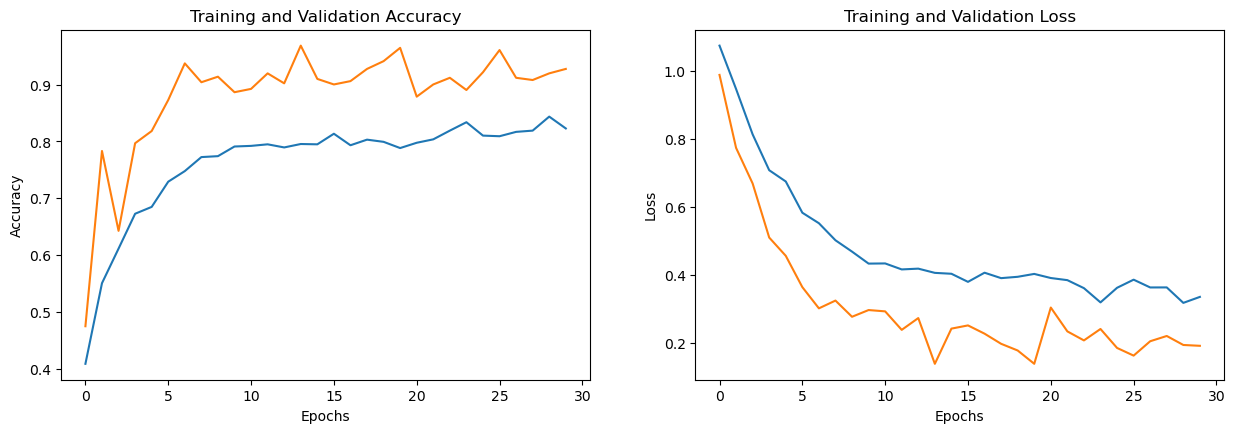

In [21]:
import matplotlib.pyplot as plt

plt.figure( figsize= (15 , 10 ))

plt.subplot(2,2,1)
plt.plot(range(EPOCHS) , model_history.history['accuracy']  , label='Training Accuracy')
plt.plot(range(EPOCHS) , model_history.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.subplot(2,2,2)
plt.plot(range(EPOCHS) ,model_history.history['loss'] , label='Training Loss')
plt.plot(range(EPOCHS) , model_history.history['val_loss'] , label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()

# Get Classification Report 

              precision    recall  f1-score   support

           0       0.31      0.35      0.33       100
           1       0.44      0.49      0.46       128
           2       0.37      0.26      0.30       100

    accuracy                           0.38       328
   macro avg       0.37      0.37      0.37       328
weighted avg       0.38      0.38      0.37       328



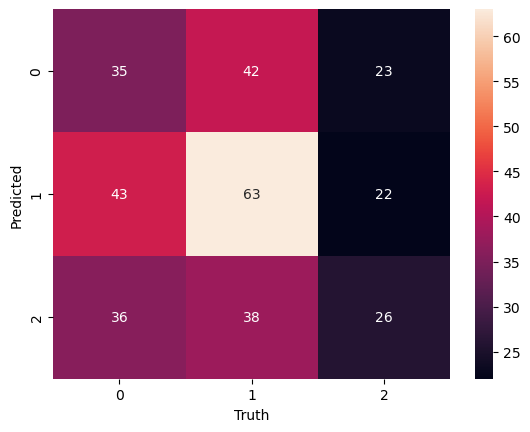

In [22]:
from sklearn.metrics import confusion_matrix , classification_report 
import seaborn as sns

print(classification_report(y_test_classes , y_pred_classes) )
sns.heatmap(confusion_matrix(y_test_classes , y_pred_classes) , annot=True)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

# Run prediction on a sample image

1/1 [==============================] - 0s 119ms/step


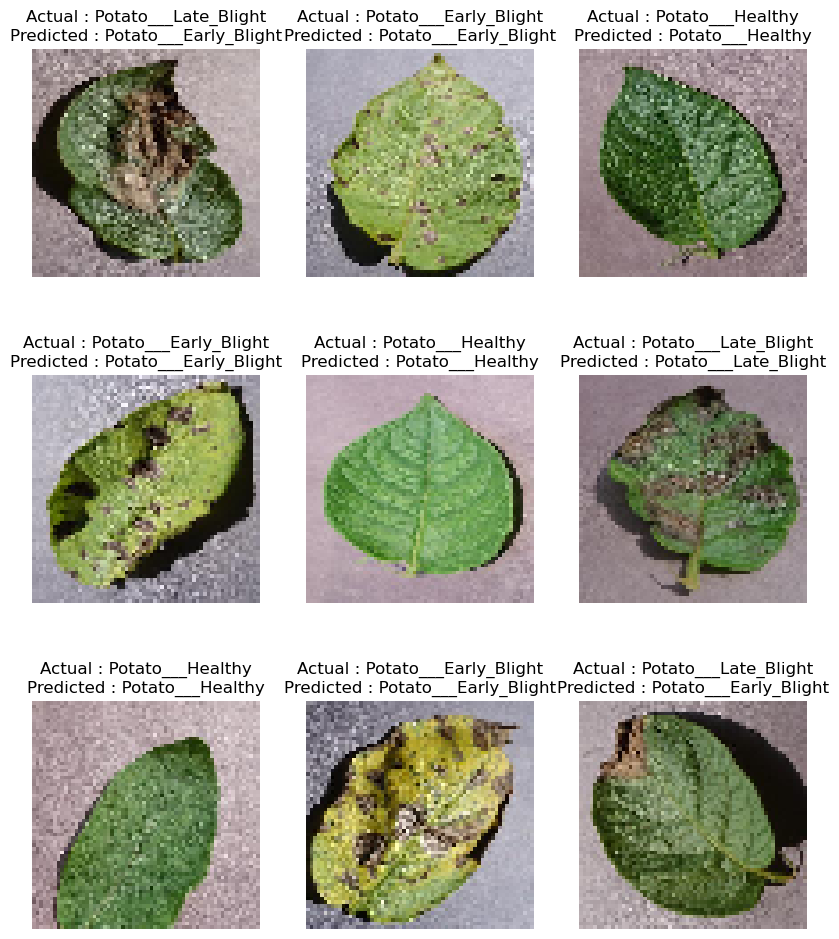

In [23]:
plt.figure( figsize= (10 , 12 ))

for image_batch,label_batch in test_generator:
    
    y_pred = model.predict(   image_batch  )
    y_pred_classes = np.argmax(y_pred, axis=1)

    for index in range(9):

        ax = plt.subplot( 3 , 3 , index + 1)
        
        img = image_batch[index]

        actual_disease = disease_class[ int(label_batch[index]) ]
        pred_disease = disease_class[y_pred_classes[index] ]
        
        plt.title('Actual : ' + actual_disease  + '\nPredicted : ' + pred_disease   )    
        plt.imshow(img)
         
        plt.axis('off')

    break

In [24]:
# Save model in h5 format so that there is just one file and we can upload that to GCP conveniently
model.save("../saved_model/potato_disease_model.h5")

c:\Users\hp\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import json
with open('../saved_model/potato_disease_mapping.json', 'w') as json_file:
    json.dump(disease_class, json_file)

# load the model


In [26]:
from tensorflow.keras.models import  load_model 
# Load the saved model
loaded_model = load_model('../saved_model/potato_disease_model.h5')

In [27]:
with open("../saved_model/potato_disease_mapping.json", 'r') as json_file:
    class_mapping = json.load(json_file)

In [28]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

img_path = WORKING_DIR + '/val/Potato___Early_Blight/0d2e2971-f1c9-4278-b35c-91dd8a22a64d___RS_Early.B 7581.JPG'
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


# Make predictions
predicted_class_index = np.argmax(model.predict(img_array) , axis=1)[0]

predicted_class = class_mapping[predicted_class_index]

print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 87ms/step
Predicted Class: Potato___Healthy
